In [15]:
import json
import numpy as np

with open(r'C:\Users\Guo\Downloads\WatchData (1).json') as w:
    data = json.load(w)

DATA=np.empty((0,128,26))

for dat in data:
    gyro_x=[]
    gyro_y=[]
    gyro_z=[]
    gyro_time=[]
    lin_x=[]
    lin_y=[]
    lin_z=[]
    lin_time=[]
    game_x=[]
    game_y=[]
    game_z=[]
    game_cos=[]
    game_time=[]
    grav_x=[]
    grav_y=[]
    grav_z=[]
    grav_time=[]
    
    sdata=dat['sensor_data']
    n=len(sdata)
    
    for i in range(0,n,1):
        if sdata[i]['sensor'] == 'GYROSCOPE':
            x=sdata[i]['data']['x']
            y=sdata[i]['data']['y']
            z=sdata[i]['data']['z']
            time=sdata[i]['timestamp']

            gyro_x.append(x)
            gyro_y.append(y)
            gyro_z.append(z)
            gyro_time.append(time)
        if sdata[i]['sensor'] == 'LINEAR_ACCELERATION':
            x=sdata[i]['data']['x']
            y=sdata[i]['data']['y']
            z=sdata[i]['data']['z']
            time=sdata[i]['timestamp']

            lin_x.append(x)
            lin_y.append(y)
            lin_z.append(z)
            lin_time.append(time)
        if sdata[i]['sensor'] == 'GRAVITY':
            x=sdata[i]['data']['x']
            y=sdata[i]['data']['y']
            z=sdata[i]['data']['z']
            time=sdata[i]['timestamp']

            grav_x.append(x)
            grav_y.append(y)
            grav_z.append(z)
            grav_time.append(time)
        if sdata[i]['sensor'] == 'GAME_ROTATION_VECTOR':
            x=sdata[i]['data']['x']
            y=sdata[i]['data']['y']
            z=sdata[i]['data']['z']
            cos=sdata[i]['data']['cos']
            time=sdata[i]['timestamp']

            game_x.append(x)
            game_y.append(y)
            game_z.append(z)
            game_cos.append(cos)
            game_time.append(time)
    
    maxGyro=max(max(gyro_x),max(gyro_y),max(gyro_z))
    minGyro=min(min(gyro_x),min(gyro_y),min(gyro_z))
    print('maxGyro: '+str(maxGyro)+'  minGyro: '+str(minGyro)+ ' range: '+str(maxGyro-minGyro))
    
    maxLin=max(max(lin_x),max(lin_y),max(lin_z))
    minLin=min(min(lin_x),min(lin_y),min(lin_z))
    print('maxLin: '+str(maxLin)+'  minLin: '+str(minLin)+ ' range: '+str(maxLin-minLin))

    maxGrav=max(max(grav_x),max(grav_y),max(grav_z))
    minGrav=min(min(grav_x),min(grav_y),min(grav_z))
    print('maxGrav: '+str(maxGrav)+'  minGrav: '+str(minGrav) + ' range: '+str(maxGrav-minGrav))
          
    maxGame=max(max(game_x),max(game_y),max(game_z))
    minGame=min(min(game_x),min(game_y),min(game_z))
    print('maxGame: '+str(maxGame)+'  minGame: '+str(minGame) + ' range: '+str(maxGame-minGame))
    
    len_array=[len(gyro_time), len(lin_time), len(grav_time), len(game_time)]
    length=min(len_array)
    
    
    len_new=0
    gyrox=[]
    gyroy=[]
    gyroz=[]

    linx=[]
    liny=[]
    linz=[]

    gravx=[]
    gravy=[]
    gravz=[]

    gamex=[]
    gamey=[]
    gamez=[]
    gamecos=[]
    validTime=[]

    for linind in range(0, length,1):
        time=lin_time[linind]

        if (time in gyro_time) & (time in grav_time) & (time in game_time):

            gyroind=gyro_time.index(time)
            gravind=grav_time.index(time)
            gameind=game_time.index(time)

            gyrox.append(gyro_x[gyroind])
            gyroy.append(gyro_y[gyroind])
            gyroz.append(gyro_z[gyroind])

            linx.append(lin_x[linind])
            liny.append(lin_y[linind])
            linz.append(lin_z[linind])

            gravx.append(grav_x[gravind])
            gravy.append(grav_y[gravind])
            gravz.append(grav_z[gravind])

            gamex.append(game_x[gameind])
            gamey.append(game_y[gameind])
            gamez.append(game_z[gameind])
            gamecos.append(game_cos[gameind])
            validTime.append(time)

            len_new+=1
        #else:
            #print(linind, time)
    
    X=np.zeros(shape=(len_new,13), dtype=float)
    X[:,0]=np.asarray(gyrox[:len_new])
    X[:,1]=np.asarray(gyroy[:len_new])
    X[:,2]=np.asarray(gyroz[:len_new])
    X[:,3]=np.asarray(linx[:len_new])
    X[:,4]=np.asarray(liny[:len_new])
    X[:,5]=np.asarray(linz[:len_new])
    X[:,6]=np.asarray(gravx[:len_new])
    X[:,7]=np.asarray(gravy[:len_new])
    X[:,8]=np.asarray(gravz[:len_new])
    X[:,9]=np.asarray(gamex[:len_new])
    X[:,10]=np.asarray(gamey[:len_new])
    X[:,11]=np.asarray(gamez[:len_new])
    X[:,12]=np.asarray(gamecos[:len_new])

    window=128
    XX=np.empty(shape=(len_new-window+1, window, 26))
    counter=0
    uncounter=0

    for i in range(0,len_new-window+1,1):
        if(validTime[i+window-1]-validTime[i]<0.02*1000000000*130):
            XX[counter,:, :13] = X[i : i+window, :]
            counter+=1
        else:
            uncounter+=1
    print("counter: "+str(counter))
    print("unvalid:"+str(uncounter))

    for j in range(0,counter,1):
        for k in range(0,13,1):
            fft=np.fft.fft(XX[j,:,k]-np.mean(XX[j,:,k]))
            XX[j,:,k+13]=abs(fft)
    DATA=np.append(DATA,XX[:counter,:,:],axis=0)

np.save('./watch.npy', DATA)

maxGyro: 16.129043579101562  minGyro: -13.754364013671875 range: 29.883407592773438
maxLin: 30.75705337524414  minLin: -23.534732818603516 range: 54.291786193847656
maxGrav: 9.80533218383789  minGrav: -9.803351402282715 range: 19.608683586120605
maxGame: 0.9864153861999512  minGame: -0.9937034249305725 range: 1.9801188111305237
counter: 1747
unvalid:920
maxGyro: 14.478485107421875  minGyro: -10.4471435546875 range: 24.925628662109375
maxLin: 19.994844436645508  minLin: -13.428689002990723 range: 33.42353343963623
maxGrav: 9.660650253295898  minGrav: -9.767040252685547 range: 19.427690505981445
maxGame: 0.9909073710441589  minGame: -0.9891846776008606 range: 1.9800920486450195
counter: 1061
unvalid:254
maxGyro: 13.352066040039062  minGyro: -10.507003784179688 range: 23.85906982421875
maxLin: 38.63266372680664  minLin: -26.882694244384766 range: 65.5153579711914
maxGrav: 9.801264762878418  minGrav: -9.313580513000488 range: 19.114845275878906
maxGame: 0.8322150707244873  minGame: -0.9982

In [2]:
DATA.shape

(11196, 128, 26)

4.477081298828125

In [14]:
(validTime[i+window-1]-validTime[i])

4310716565

In [20]:
0.02*1000000000*130

2600000000.0

In [2]:
len(DATA)

10

/home/xing/.conda/envs/tf_cpu/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


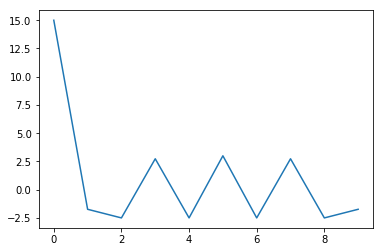

In [27]:
import matplotlib.pyplot as plt
a=[1,2,3,4,5,0,0,0,0,0]
b=np.fft.fft(a)
plt.plot(b)